<a href="https://colab.research.google.com/github/hscrown/kobart-finetuning/blob/main/kobart_fine_tuning_trying_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tensorflow rouge nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import torch
print(torch.cuda.is_available())
# '''
#   CPU 환경일 경우: False
#   GPU 환경일 경우: True
# '''

True


In [5]:
# transformers 버전  다운그레이드
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


# 데이터로드 및 전처리

In [6]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence

# 데이터셋 로드
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/634_sample.csv')

# 데이터셋 분할 (학습 데이터와 검증 데이터로 나누기)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenizer 불러오기
tokenizer = AutoTokenizer.from_pretrained("ainize/kobart-news")

# 데이터 전처리 함수 정의
def preprocess_data(data, max_input_length=512, max_target_length=150):
    input_texts = data['Text'].tolist()
    target_texts = data['Summary'].tolist()

    input_encodings = tokenizer(input_texts, truncation=True, padding='max_length', max_length=max_input_length, return_tensors='pt')
    target_encodings = tokenizer(target_texts, truncation=True, padding='max_length', max_length=max_target_length, return_tensors='pt')

    return input_encodings, target_encodings


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/682k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

# DataLoader 설정 및 모델 불러오기

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSeq2SeqLM, AdamW, get_scheduler

# 데이터 전처리
train_encodings, train_target_encodings = preprocess_data(train_data)
val_encodings, val_target_encodings = preprocess_data(val_data)

# DataLoader 설정
train_dataset = torch.utils.data.TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_target_encodings['input_ids'],
    train_target_encodings['attention_mask']
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_target_encodings['input_ids']),
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

# 모델 불러오기
model = AutoModelForSeq2SeqLM.from_pretrained("ainize/kobart-news")

# GPU 사용 (선택적)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


<ipython-input-7-f5239fca2bb2>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
<ipython-input-7-f5239fca2bb2>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['attention_mask']),
<ipython-input-7-f5239fca2bb2>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_target_encodings['input_ids']),


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

# Optimizer 및 스케줄러 설정 및 학습 루프, 검증루프

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_scheduler
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Optimizer 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 20
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=500, num_training_steps=len(train_loader) * num_epochs)
batch_size = 4

# 얼리스타핑 초기
best_val_loss = float('inf')
patience = 3
current_patience = 0

# 손실 값 저장 리스트
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        target_ids = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=target_ids[:, :-1], labels=target_ids[:, 1:].contiguous())
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {average_loss:.4f}")

    # 검증 루프
    model.eval()
    epoch_val_losses = []

    for batch in val_loader:
        input_ids, attention_mask, target_ids = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), decoder_input_ids=target_ids[:, :-1].to(device), labels=target_ids[:, 1:].contiguous().to(device))

        loss = outputs.loss
        epoch_val_losses.append(loss.item())

    avg_val_loss = np.mean(epoch_val_losses)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")

    # 얼리 스타핑 설정
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping")
            break

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/20] Average Loss: 1.1443
Epoch [1/20] Validation Loss: 0.8808
Epoch [2/20] Average Loss: 0.8205
Epoch [2/20] Validation Loss: 0.6454
Epoch [3/20] Average Loss: 0.6176
Epoch [3/20] Validation Loss: 0.5300
Epoch [4/20] Average Loss: 0.4919
Epoch [4/20] Validation Loss: 0.4580
Epoch [5/20] Average Loss: 0.3954
Epoch [5/20] Validation Loss: 0.4074
Epoch [6/20] Average Loss: 0.3310
Epoch [6/20] Validation Loss: 0.3889
Epoch [7/20] Average Loss: 0.2831
Epoch [7/20] Validation Loss: 0.3688
Epoch [8/20] Average Loss: 0.2514
Epoch [8/20] Validation Loss: 0.3646
Epoch [9/20] Average Loss: 0.2267
Epoch [9/20] Validation Loss: 0.3573
Epoch [10/20] Average Loss: 0.2008
Epoch [10/20] Validation Loss: 0.3576
Epoch [11/20] Average Loss: 0.1819
Epoch [11/20] Validation Loss: 0.3525
Epoch [12/20] Average Loss: 0.1629
Epoch [12/20] Validation Loss: 0.3523
Epoch [13/20] Average Loss: 0.1515
Epoch [13/20] Validation Loss: 0.3560
Epoch [14/20] Average Loss: 0.1379
Epoch [14/20] Validation Loss: 0.3

# 성능 지표 출력

In [11]:
from rouge import Rouge

# 검증 데이터에 대한 성능 지표 계산
val_outputs = []

for i in range(0, len(val_data), batch_size):
    input_batch = torch.tensor(val_encodings['input_ids'][i:i+batch_size]).to(device)
    attention_mask_batch = torch.tensor(val_encodings['attention_mask'][i:i+batch_size]).to(device)
    target_batch = torch.tensor(val_target_encodings['input_ids'][i:i+batch_size]).to(device)
    target_attention_mask_batch = torch.tensor(val_target_encodings['attention_mask'][i:i+batch_size]).to(device)

    with torch.no_grad():
        # 모델에 입력 전달하여 요약 생성
        outputs = model(input_ids=input_batch, attention_mask=attention_mask_batch, decoder_input_ids=target_batch[:, :-1], labels=target_batch[:, 1:].contiguous())

    loss = outputs.loss
    val_losses.append(loss.item())

    # 요약 생성
    generated_ids = model.generate(input_ids=input_batch, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    val_outputs.extend(generated_ids.tolist())

# 검증 데이터에 대한 BLEU 점수 계산
reference_texts = [tokenizer.decode(val_target_encodings['input_ids'][i], skip_special_tokens=True) for i in range(len(val_data))]
candidate_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in val_outputs]

# 가장 짧은 길이의 텍스트 리스트 길이 계산
min_length = min(len(reference_texts), len(candidate_texts))

# 리스트 개수를 가장 짧은 길이에 맞춤
reference_texts = reference_texts[:min_length]
candidate_texts = candidate_texts[:min_length]

# BLEU 점수 계산
bleu_score = corpus_bleu([[text.split()] for text in reference_texts], [text.split() for text in candidate_texts], smoothing_function=SmoothingFunction().method1)

# ROUGE 점수 계산
rouge = Rouge()
scores = rouge.get_scores(candidate_texts, reference_texts, avg=True)

# 평균 성능 지표 출력
avg_val_loss = np.mean(val_losses)
print(f"Validation Loss: {avg_val_loss:.4f} BLEU Score: {bleu_score:.4f}")
print(f"ROUGE Scores: {scores}")


<ipython-input-11-47230864d68a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_batch = torch.tensor(val_encodings['input_ids'][i:i+batch_size]).to(device)
<ipython-input-11-47230864d68a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask_batch = torch.tensor(val_encodings['attention_mask'][i:i+batch_size]).to(device)
<ipython-input-11-47230864d68a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_batch = torch.tensor(val_target_encodings['input_ids'][i:i+batch_size]).to(device)
<ipython-input-11-47230864d68a>:1

Validation Loss: 0.3691 BLEU Score: 0.5538
ROUGE Scores: {'rouge-1': {'r': 0.707138631422335, 'p': 0.7622773465740452, 'f': 0.7259139127849561}, 'rouge-2': {'r': 0.6430702942363589, 'p': 0.6908719199753321, 'f': 0.6587400417066148}, 'rouge-l': {'r': 0.7043753923594431, 'p': 0.7593526846104554, 'f': 0.7231099775023028}}


In [17]:
# 샘플 데이터 출력 (5개)
sample_size = 5
samples = []

for i in range(min(sample_size, len(val_data))):
    reference_text = tokenizer.decode(val_target_encodings['input_ids'][i], skip_special_tokens=True)
    candidate_text = tokenizer.decode(val_outputs[i], skip_special_tokens=True)
    gold_text = tokenizer.decode(val_target_encodings['input_ids'][i], skip_special_tokens=True)
    samples.append((reference_text, candidate_text, gold_text))
    print(f"Reference: {reference_text}")
    print(f"Candidate: {candidate_text}")
    print(f"Gold: {gold_text}")
    print()

Reference: 피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 하여 주문과 같이 형을 정한다.
Candidate: 피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 려하여 주문과 같이 형을 정한다.
Gold: 피고인이 사건 범행을 인정하면서 반성하고 있는 피해자와 원만히 합의한 동종 범죄로 처벌 받은 전력이 없는 점과 밖에 피고인의 연령 환경 범행의 동기와 경위 범행 정황 형법 51조가 정한 여러 양형 조건을 종합적으로 하여 주문과 같이 형을 정한다.

Reference: 피고인이 별지 목록 기재와 같은 의약품들에 관하여 발급한 처방전은 앞서 바와 같이 의약분업을 전제로 환자로 하여금 약사에게 약을 조제 받도록 하기 위한 용도로 작성 교부된 처방전이라 없는 검사가 제출한 증거들 만으로는 피고인이 사건에 관하여 의료법 17조 항이 정한 처방전 작성 부하였음을 전제로 주위적 공소사실을 인정하기 어렵고 달리 이를 인정할 증거가 없다. 마약사범 등의 수용자들에게 대면 진료 없이 정신성의약품들이 무분별하게 교부되는 것은 엄격하게 규제되어야 하는 등에 비추어 보면 피고인은 일부 수용자들을 직접 진찰하지 않은 증명서를 작성하여 수용자의 위임을 받은 교도관에게 이를 교부한 사실이 인정
Candidate: 그럼에도 불구하고 예비적 공소사실을 무죄로 판단한 원심판결에는 사실을 오인하여 판결에 영향을 미친 위법이 있으므로 이를 지적하는 검사의 주장은 이유 있다. 그럼에도 불구하고 예비적 공소사실을 무죄로 판단한 원심판결에는 사실을 오인하여 판결에 영향을 미친 위법이 있으므로 이를 지적하는 검사의 주장은 이유 있다. 그럼에도 불구하고 예비적 공소사실을

# train, validation loss 시각화

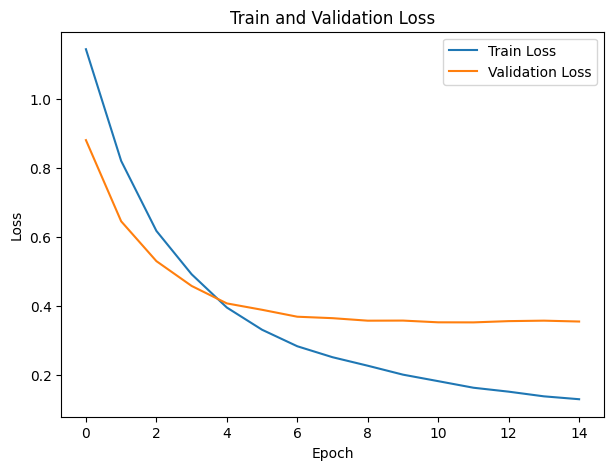

In [36]:
# 훈련 및 검증 손실 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(train_losses[:epoch+1], label="Train Loss")
plt.plot(val_losses[:epoch+1], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss")
plt.show()


# 모델 저장

In [37]:
# 학습된 모델 저장
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/oliveKobart12")

# 저장한 모델 불러와서 테스트 및 예시 출력

In [38]:
from transformers import BartForConditionalGeneration

# 저장된 모델 불러오기
model_path = "/content/drive/MyDrive/Colab Notebooks/oliveKobart12"
model = BartForConditionalGeneration.from_pretrained(model_path)

# 모델을 GPU로 옮기기
model.to(device)

# 텍스트 요약 테스트
input_text = "피고인은 원심에서도 이 부분 항소이유와 동일한 취지의 주장을 하였고, 원심은 피고인과 변호인의 주장에 대한 판단이라는 제목 아래 이에 관한 판단을 자세하게 설시하여 위 주장을 배척하였다.원심의 판단을 기록과 면밀히 대조하여 살펴보면 충분히 정당하다고 수긍할 수 있고, 원심판결에 피고인의 주장과 같은 사실오인의 위법이 있다고 판단되지 않는다. 따라서 피고인의 이 부분 주장은 이유 없다. 이 사건 범행은 피고인이 여러 명이 같이 자고 있는 방에서 술에 만취하여 잠이 든 19세의 피해자를 간음한 사안으로 그 죄질이 좋지 않다. 피해자가 이 사건 범행으로 인하여 상당한 성적 수치심과 정신적 고통을 겪고 있을 것임에도, 피고인은 피해자와 합의 하에 성관계를 가졌다고 주장하는 등 납득할 수 없는 변명으로 일관하고 있는 점, 피고인은 특수강간 등의 범죄사실로 소년보호처분을 받은 전력이 있는 점 등은 피고인에게 불리한 사정이다. 반면, 피고인이 당심에 이르러 피해자와 합의한 점 등은 피고인에게 유리한 사정이다. 그밖에 피고인의 나이, 성행, 환경, 가족관계, 범행의 동기와 경위, 범행의 방법과 결과, 범행 전후의 정황 등 여러 가지 양형의 조건들 및 양형기준의 권고형량범위를 종합하여 보면, 원심이 피고인에 대하여 선고한 형이 너무 무거워서 부당하다고 판단된다. 따라서 피고인의 이 부분 주장은 이유 있다."
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1024, truncation=True).to(device)

# 모델에 입력 전달하여 요약 생성
generated_ids = model.generate(input_ids.to(device), max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)

# 요약문 출력
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("요약문:", generated_text)



You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


요약문: 밖에 피고인의 나이, 환경, 가족관계, 범행의 동기와 경위, 범행의 방법과 결과, 범행 전후의 정황 등 여러 가지 양형의 조건들 및 양형기준의 권고 형량범위를 종합하여 보면, 원심이 피고인에 대하여 선고한 형이 너무 무거워서 부당 하다고 판단된다. 피해자가 이 사건 범행으로 인하여 상당한 성적 수치심과 정신적 고통을 겪고 있을 것임에도 피고인은 피해자와 합의 하에 성관계를 가졌다고 주장하는 등 납득할 수 없는 변명으로 일관하고 있는 점, 피고인은 특수강간 등의 범죄사실로 소년보호처분을 받은 전력이 있는 점 등은 피고인에게 불리한 사정이다. 원심의 판단을 기록과 면밀히 대조하여 살펴보면 충분히 정당하다고 수긍할 수 있고, 원심판


In [39]:
# requirements.txt 생성
!pip freeze > requirements.txt